# Actividad N° 06: Clustering

## Integrantes

**Grupo N° 03**

- Adriana Villalobos
- Gustavo Ledesma
- Alejo Cuello

## Descripción de la actividad

Trabajamos sobre el conjunto de datos *aw_fb_data.csv* de Apple Watch y Fitbit Data. El objetivo de la actividad aplicar clustering para agrupar los datos y describir cada uno de estos clusters.

# Consigna

**Consideraciones**

- Nos basamos en el dataset de Kaggle: Apple Watch and Fitbit data.
- Repliquen el notebook y apliquen lo aprendido a este dataset.

**Preparación de datos**

- Eliminar la columna X1 y hacer un get dummies.

**KMeans**

- Probar con n_clusters=3.
- Gráfico 3D para las columnas x='gender', y='age', z='calories' y color='activity'

**HDBSCAN**

- Probar con min_cluster_size=80.

**Output**

- Hagan un storytelling para 3 cluster que les llamo la atención, tanto para KMeans y HDBSCAN.

# Código

## Importación de librerías y datos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from funpymodeling.exploratory import status
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
data = pd.read_csv("../aw_fb_data.csv", sep=",", index_col=0)
data.head(3)

,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,device,activity
1,1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.0,19.531302,0.138520,1.0,0.089692,apple watch,Lying
2,2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.0,19.453390,0.137967,1.0,0.102088,apple watch,Lying
3,3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.0,19.540825,0.138587,1.0,0.115287,apple watch,Lying


## Análisis inicial de los datos

In [3]:
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,X1,0,0.0,0,0.000000,3656,int64
1,age,0,0.0,0,0.000000,24,int64
2,gender,0,0.0,3279,0.523467,2,int64
3,height,0,0.0,0,0.000000,28,float64
4,weight,0,0.0,0,0.000000,43,float64
5,steps,0,0.0,0,0.000000,3919,float64
6,hear_rate,0,0.0,0,0.000000,4514,float64
7,calories,0,0.0,0,0.000000,2136,float64
8,distance,0,0.0,0,0.000000,4863,float64
9,entropy_heart,0,0.0,18,0.002874,56,float64


## Preparación inicial de los datos

In [4]:
data.drop(columns=["X1"], inplace=True)

In [5]:
#Existen solo 10 registros duplicados. Habría que investigar, pero creo que podrían existir mediciones duplicadas.
data.duplicated().value_counts()

False    6254
True       10
Name: count, dtype: int64

In [6]:
activity_order = {
    "Lying": 0,
    "Sitting": 1,
    "Self Pace walk": 2,
    "Running 3 METs": 3,
    "Running 5 METs": 4,
    "Running 7 METs": 5
}

data['activity_order'] = data['activity'].map(activity_order)
data.drop(columns="activity",inplace=True)

In [7]:
# Convierto columnas tipo object en tipo category para optimizar
for col in list(data.select_dtypes(["object"]).columns):
    data[col] = data[col].astype("category")
    
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6264 entries, 1 to 6264
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   6264 non-null   int64   
 1   gender                6264 non-null   int64   
 2   height                6264 non-null   float64 
 3   weight                6264 non-null   float64 
 4   steps                 6264 non-null   float64 
 5   hear_rate             6264 non-null   float64 
 6   calories              6264 non-null   float64 
 7   distance              6264 non-null   float64 
 8   entropy_heart         6264 non-null   float64 
 9   entropy_setps         6264 non-null   float64 
 10  resting_heart         6264 non-null   float64 
 11  corr_heart_steps      6264 non-null   float64 
 12  norm_heart            6264 non-null   float64 
 13  intensity_karvonen    6264 non-null   float64 
 14  sd_norm_heart         6264 non-null   float64 
 15  steps_tim

## Agrupamiento de registros por persona

In [8]:
data = pd.get_dummies(data, drop_first=True)
data.head(3)

,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,activity_order,device_fitbit
1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.0,19.531302,0.138520,1.0,0.089692,0,False
2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.0,19.453390,0.137967,1.0,0.102088,0,False
3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.0,19.540825,0.138587,1.0,0.115287,0,False


In [9]:
data_by_person = data.groupby(["age","gender","height","weight","device_fitbit"]).mean(numeric_only=True).reset_index()
data_by_person

,age,gender,height,weight,device_fitbit,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,activity_order
0,18,1,180.3,90.0,False,296.101174,109.335315,4.968887,0.123471,6.189825,5.987703,79.000000,0.189467,30.335315,0.246629,14.454766,58.250764,2.479452
1,18,1,180.3,90.0,True,1.000000,7.033227,11.555556,1.000000,0.104419,0.000000,3.000000,1.000000,4.033227,0.020267,17.005300,1.000000,2.777778
2,18,1,183.0,70.3,False,225.590857,102.258322,11.096949,0.089241,6.228819,6.175485,58.134333,0.506609,44.123989,0.306703,9.952422,59.545779,2.400000
3,18,1,183.0,70.3,True,5.119270,73.805372,39.887097,7.514856,5.076305,4.920719,45.359655,0.774142,28.445717,0.181599,13.645239,52.359849,2.177419
4,19,0,172.0,72.5,False,10.459006,87.931998,11.282742,0.007388,5.940269,6.108524,78.250000,-0.251424,9.681998,0.078876,2.558243,0.100272,1.681159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,49,0,152.0,48.6,True,9.027512,50.979277,31.227273,13.946172,6.114369,0.420655,13.777778,0.816007,37.201500,0.236617,32.553592,1856.297564,2.136364
94,53,0,143.0,49.2,False,48.092836,84.908736,0.629345,0.036761,6.221612,6.247928,66.817797,0.545529,18.090939,0.180580,4.993279,13.330009,2.289474
95,53,0,143.0,49.2,True,5.894737,76.482718,44.125000,15.736842,6.247928,6.247928,75.668850,1.000000,0.813868,0.008911,0.151300,92.679224,2.289474
96,56,1,164.0,62.0,False,50.904798,91.640007,0.279691,0.032069,5.745907,5.909440,65.000000,0.088155,26.640007,0.269091,16.280580,8.950636,2.444444


## Transformación de columnas

In [10]:
numeric_cols = list(data.select_dtypes(["int64","float64"]).columns)
# categorical_cols = list(data.select_dtypes(["category"]).columns)

ct = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    # ("cat", OneHotEncoder(drop="first"), categorical_cols)
])

In [11]:
data_transformed = ct.fit_transform(data_by_person)

new_columns_names = [col.replace("num__","") if "num__" in col else col.replace("cat__","") for col in ct.get_feature_names_out()]

data_transformed = pd.DataFrame(data_transformed, columns=[new_columns_names])
data_transformed["device_fitbit"] = data_by_person["device_fitbit"].astype("int64")

data_transformed.head(3)

,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,activity_order,device_fitbit
0,-1.263994,1.063219,0.999448,1.355732,1.381247,0.999163,-0.843716,-0.420008,0.382882,0.460808,0.525542,-0.359420,0.521196,0.718555,0.396741,-0.281322,0.053805,0
1,-1.263994,1.063219,0.999448,1.355732,-0.648664,-2.965852,-0.471963,-0.394423,-3.149257,-2.223982,-2.069831,1.158990,-0.798179,-0.862891,0.643500,-0.307164,1.218471,1
2,-1.263994,1.063219,1.257502,-0.025032,0.896228,0.724873,-0.497847,-0.421007,0.405515,0.545006,-0.187013,0.234698,1.212869,1.138257,-0.038852,-0.280737,-0.256377,0


In [12]:
data_transformed.describe()

,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,activity_order,device_fitbit
count,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,98.000000,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,98.000000
mean,-1.268826e-16,-1.178196e-16,1.524857e-15,-2.265761e-17,-6.004267e-17,2.809544e-16,0.000000,-5.324539e-17,3.908438e-17,1.280155e-16,-1.903239e-16,-9.063045e-17,3.710184e-17,2.067507e-17,-1.574704e-16,3.455286e-17,-1.637296e-15,0.500000
std,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,1.005141e+00,0.502571
min,-1.263994e+00,-9.405399e-01,-2.565523e+00,-1.938477e+00,-6.486641e-01,-2.965852e+00,-1.120721,-4.233961e-01,-3.209865e+00,-2.223982e+00,-2.069831e+00,-2.119920e+00,-1.381729e+00,-2.900793e+00,-9.885312e-01,-3.075703e-01,-3.062738e+00,0.000000
25%,-7.119826e-01,-9.405399e-01,-9.407373e-01,-7.119097e-01,-6.149947e-01,-3.727415e-01,-0.988050,-4.218783e-01,2.630079e-01,3.299147e-01,-2.940492e-01,-7.502175e-01,-9.595661e-01,-9.497492e-01,-7.741914e-01,-3.039090e-01,-3.690183e-01,0.000000
50%,-1.599708e-01,-9.405399e-01,-1.761322e-01,-4.605885e-02,-4.993520e-01,-1.904688e-01,-0.392333,-4.052421e-01,3.713316e-01,5.123325e-01,2.694201e-01,-2.396765e-01,-9.199280e-02,-8.321602e-02,-2.672268e-01,-2.805693e-01,-1.631990e-01,0.500000
75%,3.920411e-01,1.063219e+00,9.707753e-01,6.057741e-01,2.736895e-01,7.191806e-01,1.161837,3.572122e-02,4.044694e-01,5.602371e-01,4.239699e-01,1.158990e+00,4.740057e-01,7.473617e-01,3.259297e-01,-2.657811e-01,1.340241e-01,1.000000
max,2.931296e+00,1.063219e+00,2.022107e+00,3.107971e+00,4.438922e+00,2.474470e+00,1.848056,4.522113e+00,5.488314e-01,6.796328e-01,3.120916e+00,1.158990e+00,4.142152e+00,2.787674e+00,3.132048e+00,6.656606e+00,4.316892e+00,1.000000


In [13]:
# Revisando que no haya "personas repetidas" con el mismo dispositivo 
data_by_person.duplicated().value_counts()

False    98
Name: count, dtype: int64

## Correlación entre las variables

<Axes: >

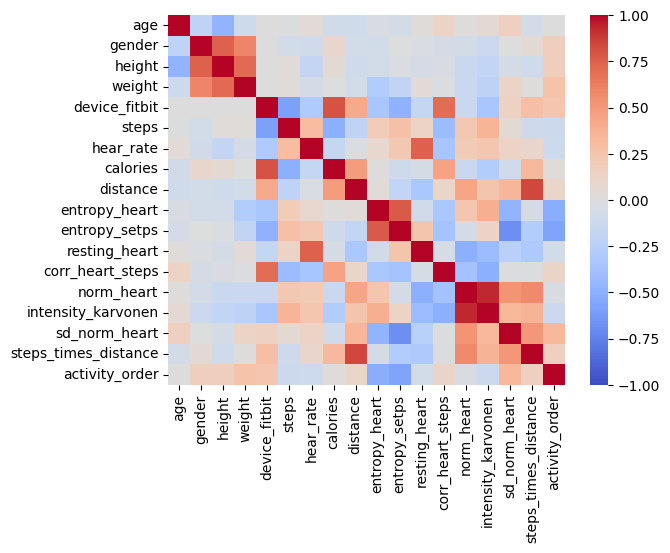

In [14]:
sns.heatmap(data=data_by_person.corr(), cmap="coolwarm", vmin=-1, vmax=1)

In [ ]:
corr_series = data_by_person.corr().unstack()
corr_df = corr_series.reset_index()
corr_df.columns = ['Variable_1', 'Variable_2', 'Correlation_Value']

mask = corr_df['Variable_1'] < corr_df['Variable_2'] #Compara los strings para eliminar la diagonal y una mitad repetida de la matriz
filtered_corr_df = corr_df[mask]

highest_correlations = filtered_corr_df.iloc[
    # filtered_corr_df['Correlation_Value'].abs().argsort()[::-1]
    filtered_corr_df['Correlation_Value'].argsort()[::-1]
]

1      101
2       35
3      146
4      145
5      123
      ... 
318     50
319     87
320     58
321     81
322    129
Name: Correlation_Value, Length: 153, dtype: int64

In [29]:
pd.concat([highest_correlations.head(5), highest_correlations.tail(5)])


,Variable_1,Variable_2,Correlation_Value
265,intensity_karvonen,norm_heart,0.930796
160,distance,steps_times_distance,0.837626
130,calories,device_fitbit,0.797584
172,entropy_heart,entropy_setps,0.772949
119,hear_rate,resting_heart,0.745019
245,norm_heart,resting_heart,-0.504658
315,activity_order,entropy_heart,-0.515260
316,activity_order,entropy_setps,-0.565171
77,device_fitbit,steps,-0.591240
195,entropy_setps,sd_norm_heart,-0.683176


## PCA

In [51]:
pca = PCA()
data_pca_by_person = pca.fit_transform(data_by_person)

In [55]:
var = pca.explained_variance_ratio_
np.cumsum(np.round(var, decimals=4)*100)

array([ 99.52,  99.95,  99.98,  99.99, 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  ])